In [67]:
import pandas    as pd
import geopandas as geopd
import seaborn   as sea 
import matplotlib.pyplot as plt
from pyspark.sql       import SparkSession
from pyspark.sql       import functions as f
from pyspark.sql.types import *

### Data & AI - PB Fast Learning - Ciência de Dados - 1/3 Desafio

> Neste projeto ficarei usando pandas, pyspark([sql]()),  pyspark([dataframe]()) mais vou utilizar mais as duas ultimas pois já tenho um certo conhecimento em Pandas e quero aprender|fixar o conhecimento sobre o Pyspark. 

Criando Seção no spark

In [68]:
spark = SparkSession.builder\
    .appName('ProjetoSprint01-Desafio')\
    .getOrCreate()
spark.sparkContext

<SparkContext master=local[*] appName=ProjetoSprint01-Desafio>

&nbsp;

### Carregando dados usando pyspark
> Defini o tipo do Schema(com o `StructType`) para alguns Conj. dados pois estavam tipando errado o schema, por exemplo, **`geolocation_zip_code_prefix`** que seus atributos são do tipo string contedo só numero de caracteres, mas estavam sendo colocados como do tipo `integer`.

In [86]:
# olist_customers_dataset
customers     = spark.read.format('csv')\
    .option('header','True').option('delimiter',',').option('inferschema','True')\
        .load('dataset/olist_customers_dataset.csv')

# olist_geolocation_dataset
schemaGeo = StructType([ 
    StructField("geolocation_zip_code_prefix", StringType(), True),
    StructField("geolocation_lat", DoubleType(), True),
    StructField("geolocation_lng", DoubleType(), True),
    StructField("geolocation_city", StringType(), True),
    StructField("geolocation_state", StringType(), True)
])
geolocation   = spark.read.format('csv')\
    .option('header','True').option('delimiter',',').schema(schemaGeo)\
        .load('dataset/olist_geolocation_dataset.csv')

# olist_order_payments_dataset
payments      = spark.read.format('csv')\
    .option('header','True').option('delimiter',',').option('inferschema','True')\
        .load('dataset/olist_order_payments_dataset.csv')

# olist_orders_dataset
orders        = spark.read.format('csv')\
    .option('header','True').option('delimiter',',').option('inferschema','True')\
        .load('dataset/olist_orders_dataset.csv')

# olist_order_items_dataset
order_items   = spark.read.format('csv')\
    .option('header','True').option('delimiter',',').option('inferschema','True')\
        .load('dataset/olist_order_items_dataset.csv')

# olist_order_reviews_dataset
order_reviews = spark.read.format('csv')\
    .option('header','True').option('delimiter',',').option('inferschema','True')\
        .load('dataset/olist_order_reviews_dataset.csv')

# olist_products_dataset
order_product = spark.read.format('csv')\
    .option('header','True').option('delimiter',',').option('inferschema','True')\
        .load('dataset/olist_products_dataset.csv')

# olist_sellers_dataset
schemaSeller = StructType([
    StructField("seller_id", StringType(), True),
    StructField("seller_zip_code_prefix", StringType(), True),
    StructField("seller_city", StringType(), True),
    StructField("seller_state", StringType(), True)
])
sellers      = spark.read.format('csv')\
    .option('header','True').option('delimiter',',').schema(schemaSeller)\
        .load('dataset/olist_sellers_dataset.csv')

# product_category_dataset
product_cat  = spark.read.format('csv')\
    .option('header','True').option('delimiter',',').option('inferschema','True')\
        .load('dataset/product_category_name_translation.csv')

Criando uma visão temporaria , pois usarei o sql do spark para fazer as questões e melhor de entender oq estou fazendo

In [70]:
customers.createOrReplaceTempView('customers')
geolocation.createOrReplaceTempView('geolocation')
orders.createOrReplaceTempView('orders')
order_items.createOrReplaceTempView('order_items')
order_product.createOrReplaceTempView('order_product')
order_reviews.createOrReplaceTempView('order_reviews')
payments.createOrReplaceTempView('payments')
sellers.createOrReplaceTempView('sellers')
product_cat.createOrReplaceTempView('product_cat')

&nbsp;

### Quais são categorias com maior e menor receita dos ultimos 12 meses?

In [71]:
query = 'select min(order_purchase_timestamp) as tempoMin, max(order_purchase_timestamp) as tempoMax from orders;'
display(spark.sql(query).toPandas())

,tempoMin,tempoMax
0,2016-09-04 21:15:19,2018-10-17 17:30:18


> O data vão de 2016 a 2019

Usando **Sql Spark** para fazer as questões \
Fazendo o `INNER JOIN` nas repestivas tabelas abaixo e com o `order_status!=cancelado` ,pois so será computado as vendas feitas(ou seja diferente de cancelado) assim consigo obter o valor real das Receitas de um produto, vender, estado.....
> Essa logica será feitas sobre as questões adiante que pedem `receitas` de algo

In [72]:
query = '''
SELECT product_category_name , SUM(payment_value) as Receita FROM order_items as o_i
    INNER JOIN order_product as o_p ON
        o_p.product_id = o_i.product_id
    INNER JOIN orders as or ON
        or.order_id = o_i.order_id
    INNER JOIN payments as pay ON
        pay.order_id = or.order_id

    WHERE order_status != 'canceled' AND
        order_purchase_timestamp >= '2017-10-17 01:00:00' AND
        order_purchase_timestamp <= '2018-10-17 17:30:18' 
    GROUP BY product_category_name
    ORDER BY receita desc;
'''
data = spark.sql(query).toPandas()

In [73]:
data.isna().nunique()

product_category_name    2
Receita                  1
dtype: int64

In [74]:
data.loc[data['product_category_name'].isna()==True]

,product_category_name,Receita
21,None,150995.8


> Apesar de ter valores nulos isso não está afeta analise

Modificando a coluna `product_category_name` para torna-la mais legivel

In [75]:
# Tirar o `_` e colacando o ' ' (espaco vazio) usando o replace
data['product_category_name'] = data['product_category_name'].str.replace('_',' ')
# Deixando as primeiras letras de cada palavra maiuscula
data['product_category_name'] = data['product_category_name'].str.title()

Usarei seaborn e matplotlib para visualização pois ele renderiza no github, diferente do plotly

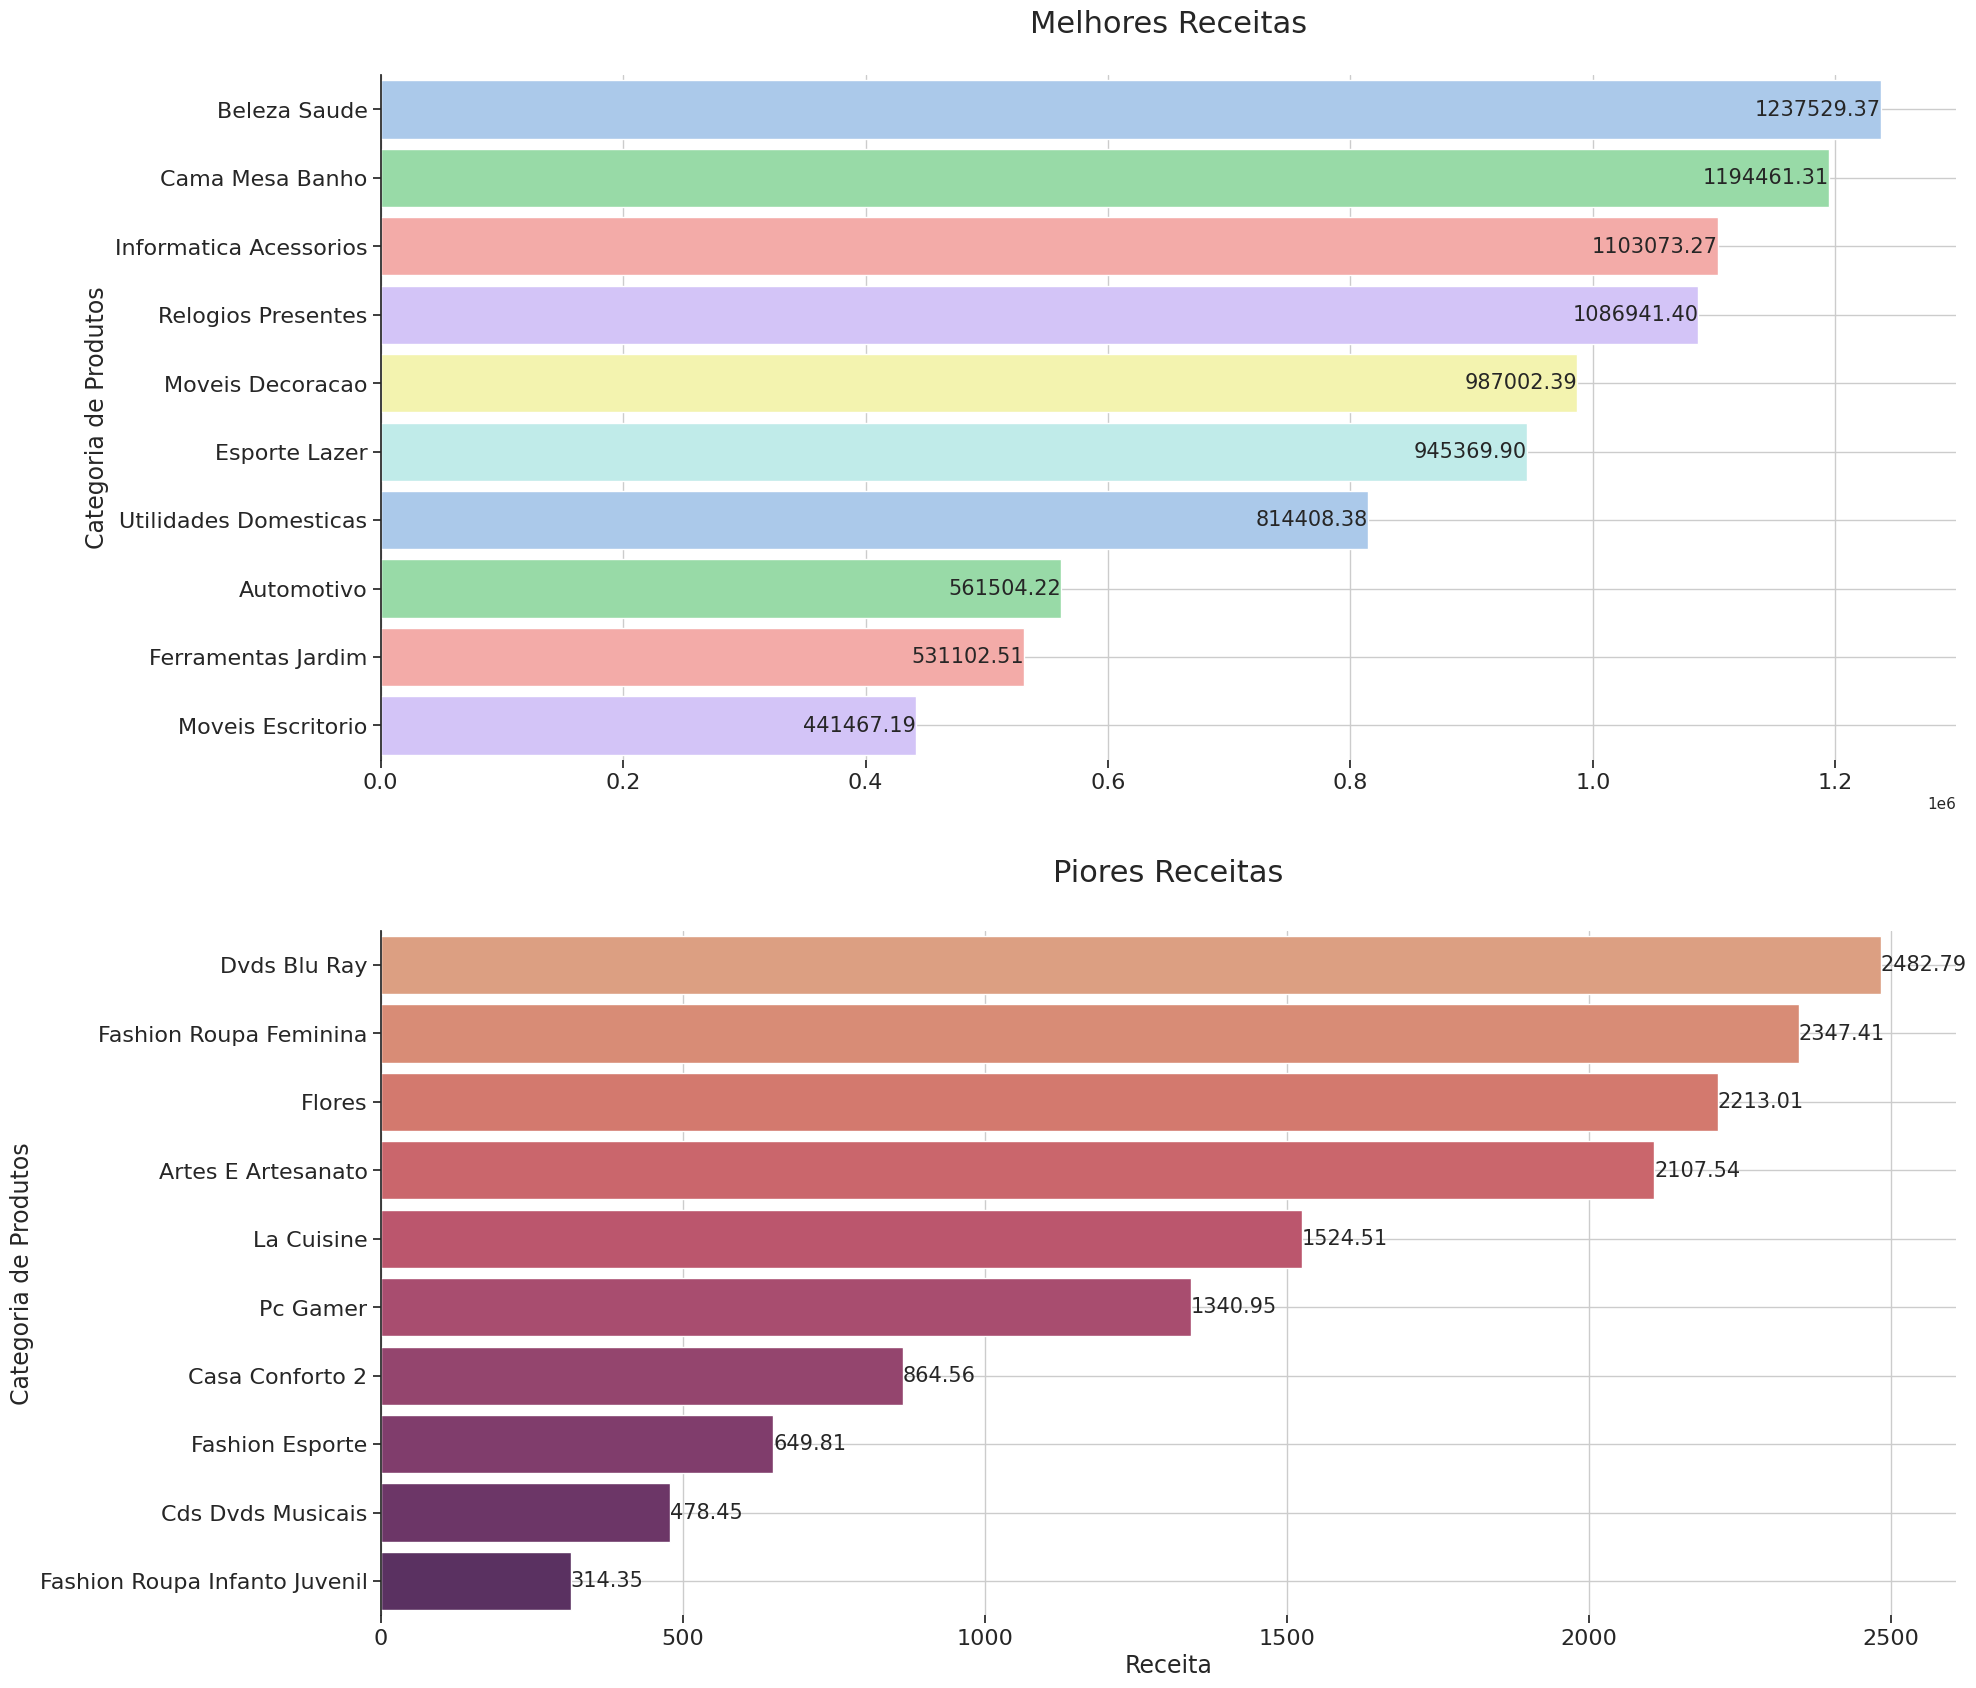

In [76]:
sea.set_theme(context='notebook',style='ticks')  # Definindo estilo
fig, ax = plt.subplots(ncols=1,nrows=2,figsize=(18,20))
fig.subplots_adjust(hspace=0.25,right=1)        # Aumenta o espaço entre os graficos

# Grafico 1 = Melhores receitas
barMelhores = sea.barplot( data = data.iloc[0:10,:], 
    y='product_category_name', x='Receita', hue='product_category_name',width=0.85,
    palette=sea.color_palette('pastel6',n_colors=10), ax = ax[0], legend=False
)

# Grafico 2 = Piores receitas
barPiores = sea.barplot(data=data.iloc[63:76,:], 
    y='product_category_name', x='Receita', hue='product_category_name',width=0.85,
    palette =  sea.color_palette('flare',n_colors=10), ax = ax[1], legend=False
)

#Colocar text nas barras do graphico fiz dessa forma para
#economizar o numero de linhas
for graph,ha in zip([barMelhores,barPiores],['right','left']):
    for p in graph.patches:
        if p.get_width() != 0:
            xy = (p.get_width(), p.get_y()+p.get_height()/2)
            graph.annotate("%.2f" % p.get_width(),xy = xy, 
                xytext = (0, 0.1), textcoords= 'offset points', ha=ha, va = "center" ,size=15)

# Modificando Layout do grafico para deixar mais bonito
for axis in ax.flatten():
    axis.set_xlabel('')
    axis.set_ylabel('Categoria de Produtos',x=10,fontsize=17)
    axis.spines[['right','top','bottom']].set_visible(False)
    axis.tick_params('y', labelsize=16)
    axis.tick_params('x', labelsize=16)         
    axis.set_axisbelow(True)
    axis.grid(True)

#Modificando o Grafico 1
ax[0].set_title('Melhores Receitas',y=1.05,fontsize=22)

#Modificando o Grafico 2
ax[1].set_title('Piores Receitas',y=1.06,fontsize=22)       # Titulo 
ax[1].set_xlabel('Receita',fontsize=17)                     # Modificando eixo x
plt.show()

&nbsp;

## Top 10 maiores sellers (maior receita)?

In [77]:
query = '''
SELECT (INITCAP(se.seller_city)|| '-' || se.seller_state) as seller ,
        ROUND(sum(payment_value),2) as receita FROM sellers AS se
    INNER JOIN order_items AS o_i ON
        o_i.seller_id = se.seller_id
    INNER JOIN payments AS py ON
        py.order_id  = o_i.order_id
    INNER JOIN orders AS o_r ON
        o_r.order_id = py.order_id
    WHERE order_status != 'canceled'  
    GROUP BY seller
    ORDER BY receita desc limit 10; 
'''
data = spark.sql(query).toPandas()

In [78]:
data.isna().nunique()

seller     1
receita    1
dtype: int64

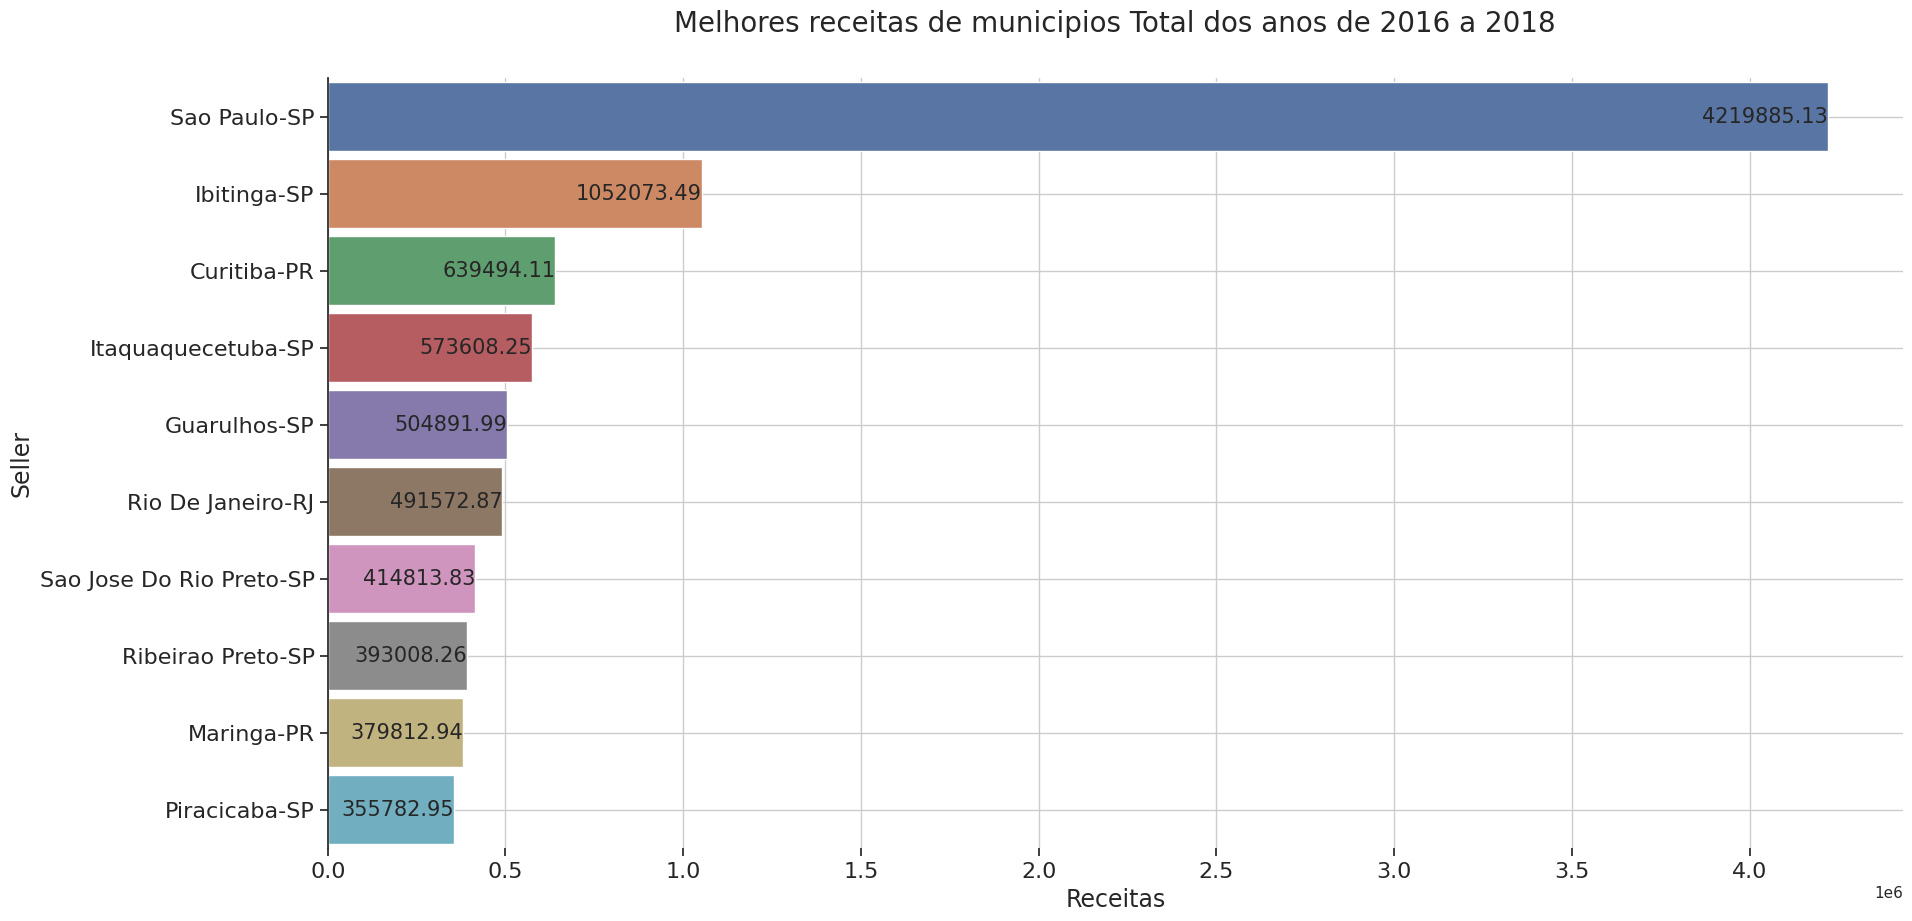

In [79]:
sea.set_theme(style="ticks")                # Definindo estilo
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(18,10))
fig.subplots_adjust(hspace=0.25,right=1)    # Aumenta o espaço entre os graficos

# Grafico 1 = Melhores receitas
barMelhores = sea.barplot( data = data.iloc[0:10,:], 
    y='seller', x='receita', hue='seller', width=0.9, ax = ax, legend=False )

#Modificando o Grafico 1
ax.set_title('Melhores receitas de municipios Total dos anos de 2016 a 2018',y=1.05,fontsize=20)
ax.set_ylabel('Seller',x=10,fontsize=17)
ax.set_xlabel('Receitas',fontsize=17)
ax.spines[['right','top','bottom']].set_visible(False)
ax.tick_params('y', labelsize=16)
ax.tick_params('x', labelsize=16)         
ax.set_axisbelow(True)
ax.grid(True)

# Colocando o valor das receitas nas barras
for p in barMelhores.patches:
    if p.get_width() != 0:
        barMelhores.annotate(("%.2f" % p.get_width()),  xy = (p.get_width(), p.get_y()+p.get_height()/2), 
        xytext = (0, 0.1), textcoords= 'offset points', ha = 'right', va = "center" ,size=15)

In [80]:
query = '''
SELECT seller_state, order_approved_at, payment_value FROM sellers AS se 
    INNER JOIN order_items AS o_i ON
        o_i.seller_id = se.seller_id
    INNER JOIN payments AS py ON
        py.order_id  = o_i.order_id
    INNER JOIN orders AS o_r ON
        o_r.order_id = py.order_id;
'''
dataSql = spark.sql(query).na.drop()

Vou usar o spark para fazer essa operação, depois passarei para pandas para visualização

In [81]:
dataSpark = dataSql.groupby(
    [f.col('seller_state') ,f.year( f.col('order_approved_at') ).alias('ano')] )\
    .agg( 
        f.round(f.sum(f.col('payment_value'))).alias('receita') )\
    .orderBy( 
        f.col('receita').desc() )
dataPd = dataSpark.toPandas()

Plotando usando um loop

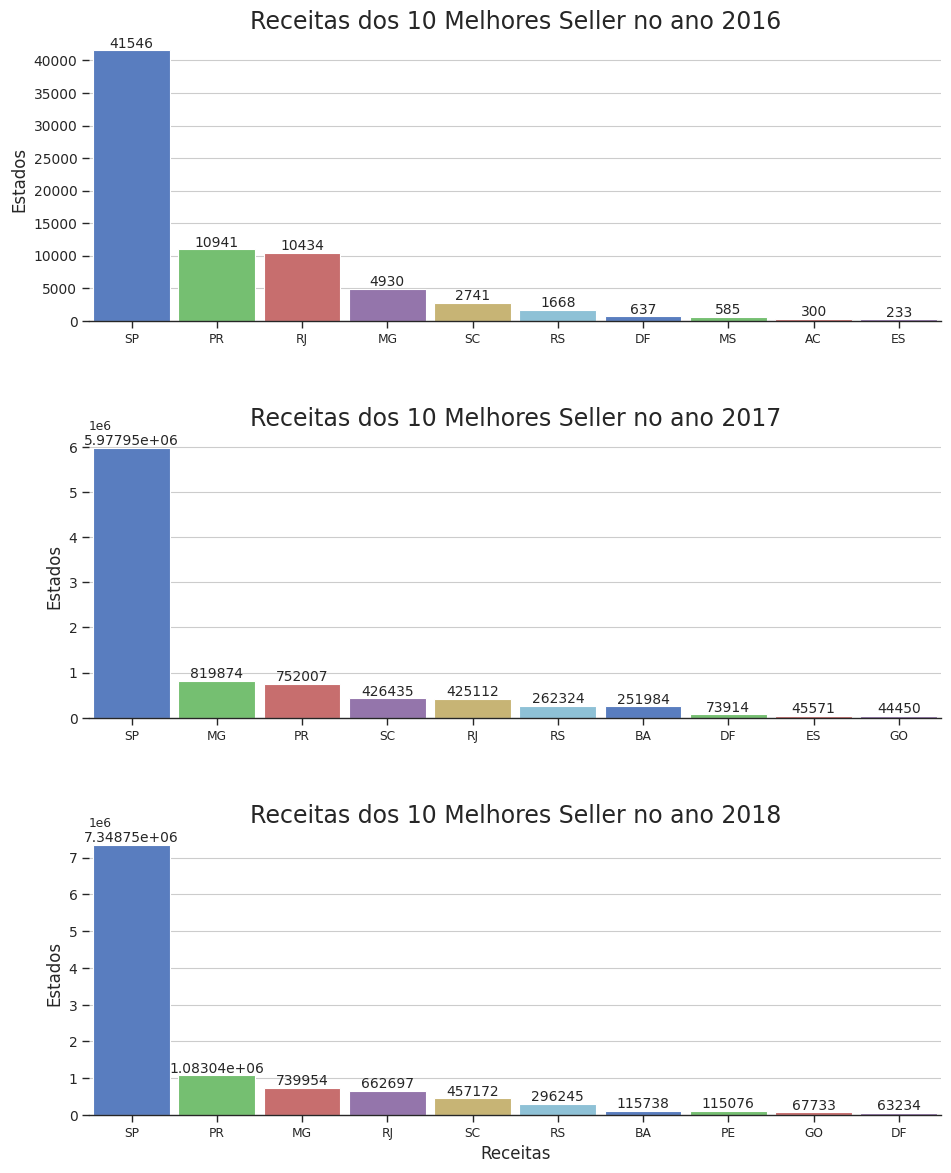

In [82]:
sea.set_theme('paper',style='ticks')
fig, ax = plt.subplots(ncols=1,nrows=3, figsize=(11,14))
fig.subplots_adjust(hspace=0.4)

for ano,axis in zip(range(2016, 2019),ax.flatten()):
    selecti = dataPd.loc[ dataPd['ano'] == ano ].iloc[0:10,:]

    bar = sea.barplot(
        data=selecti, y='receita', x='seller_state', hue='seller_state',ax=axis,
        palette=sea.color_palette('muted6',n_colors=10) , width=1,gap=0.1
    )
    axis.set_title(f'Receitas dos 10 Melhores Seller no ano {ano}',fontsize=17)
    axis.set_ylabel('Estados',fontsize=12)
    axis.set_xlabel('')
    axis.tick_params('y', labelsize=10)
    axis.spines[['right','top','left']].set_visible(False)
    axis.grid(axis='y')

    for i in bar.containers: bar.bar_label(i,fontsize=10)
axis.set_xlabel('Receitas',fontsize=12)
plt.show()

&nbsp;

## Top 10 piores sellers?

&nbsp;

## Existem sellers que vendem o mesmo produto? se sim quais são? Qual a variação de preço praticada entre os sellers?

Usarei o pandas para fazer o group by pois fica melhor de visualizar a tabela ou ela organiza melhor quando usa duas colunas para essa operação

In [83]:
query = '''
SELECT seller_state, product_category_name,price FROM sellers AS se
    INNER JOIN order_items AS o_i ON
        se.seller_id = o_i.seller_id
    INNER JOIN order_product AS op ON
        op.product_id = o_i.product_id
'''
data = spark.sql(query).na.drop().toPandas()

In [84]:
resultado = data.groupby(by=['seller_state', 'product_category_name'])['price'].mean().reset_index()
resultado.dropna(inplace=True)
resultado.head(3)

,seller_state,product_category_name,price
0,AC,livros_tecnicos,267.000000
1,AM,telefonia,392.333333
2,BA,alimentos_bebidas,124.535405


In [85]:
def VarianciaDeLojas(data:pd.DataFrame):
    dicionario = {'States':[],'Produto':[],'Variação':[]}
    for enum ,statei in data.iterrows():
        for _ ,statej in data.iloc[enum:,:].iterrows():
            if (statei['seller_state'] != statej['seller_state']):
                if (statei['product_category_name'] == statej['product_category_name']):
                    dicionario['Produto'].append(statei['product_category_name'])
                    dicionario['States'].append(statei['seller_state'] +'-'+statej['seller_state'])
                    variacao =  ((statei['price'] - statej['price']))
                    dicionario['Variação'].append(variacao)
    return pd.DataFrame(dicionario)

&nbsp;

### Ouve inflação de preço dos produtos ?

### Top 10 seller com review positivas